# TFLite runtime test from MediaPipe

[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ShawnHymel/google-coral-micro-object-detection/blob/master/notebooks/tflite-runtime-test-object-detection.ipynb)

Perform post processing according to: https://github.com/google/mediapipe/blob/8609e5fae5c89bad69995e2ffeec62a9fefc0cb9/mediapipe/calculators/tensor/tensors_to_detections_calculator.cc#L787

```
Author: Shawn Hymel
Date: December 23, 2023
License: https://opensource.org/license/0bsd/
```

In [1]:
import json
import math
import os

from PIL import Image, ImageDraw
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [49]:
# Settings
MODEL_PATH = "model_int8.tflite"
METADATA_PATH = "metadata.json"
IMAGE_PATH = "image.1a245df2.jpg"
SCORE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.1

In [50]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(MODEL_PATH)
interpreter.allocate_tensors()

In [51]:
# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']

# Get output details unique to MobileNetv2-SSD
num_anchors = output_details[0]['shape'][1]
num_locs = output_details[0]['shape'][2]
num_classes = output_details[1]['shape'][2]

# Get input quantization details (assume one input tensor)
input_type = input_details[0]['dtype']
if input_type is np.uint8:
    input_scale = input_details[0]['quantization_parameters']['scales'][0]
    input_zero_point = input_details[0]['quantization_parameters']['zero_points'][0]
elif input_type is np.float32:
    input_scale = None
    input_zero_point = None
else:
    raise TypeError("Unsupported input tensor type")

# Get location output quantization details (assume one tensor)
locs_type = output_details[0]['dtype']
if locs_type is np.uint8:
    locs_scale = output_details[0]['quantization_parameters']['scales'][0]
    locs_zero_point = output_details[0]['quantization_parameters']['zero_points'][0]
elif locs_type is np.float32:
    locs_scale = None
    locs_zero_point = None
else:
    raise TypeError("Unsupported output locations tensor type")

# Get scores output quantization details (assume one tensor)
scores_type = output_details[1]['dtype']
if scores_type is np.uint8:
    scores_scale = output_details[1]['quantization_parameters']['scales'][0]
    scores_zero_point = output_details[1]['quantization_parameters']['zero_points'][0]
elif scores_type is np.float32:
    scores_scale = None
    scores_zero_point = None
else:
    raise TypeError("Unsupported output scores tensor type")

# Print details
print(f"Input shape: {input_shape}")
print(f"Number of anchors: {num_anchors}")
print(f"Number of locations: {num_locs}")
print(f"Number of classes: {num_classes}")
print(f"Input type: {input_type}")
print(f"Input scale: {input_scale}")
print(f"Input zero point: {input_zero_point}")
print(f"Locations type: {locs_type}")
print(f"Locations scale: {locs_scale}")
print(f"Locations zero point: {locs_zero_point}")
print(f"Scores type: {scores_type}")
print(f"Scores scale: {scores_scale}")
print(f"Scores zero point: {scores_zero_point}")

Input shape: [  1 320 320   3]
Number of anchors: 19125
Number of locations: 4
Number of classes: 2
Input type: <class 'numpy.uint8'>
Input scale: 0.007843137718737125
Input zero point: 127
Locations type: <class 'numpy.uint8'>
Locations scale: 0.06343743950128555
Locations zero point: 133
Scores type: <class 'numpy.uint8'>
Scores scale: 0.00390625
Scores zero point: 0


In [52]:
# Load and preprocess the JPEG image
input_shape = input_details[0]['shape']
image = Image.open(IMAGE_PATH)
image = image.resize((input_shape[1], input_shape[2]))

# Normalize or quantize the image (depending on expected input type)
if input_type is np.uint8:
    image = np.array(image, dtype=np.uint8)
    image = np.expand_dims(image, axis=0)
elif input_type is np.float32:
    image = np.array(image, dtype=np.float32)
    image = np.expand_dims(image, axis=0)
    image /= 255.0
else:
    raise TypeError("Unsupported input tensor type")

# Set the input tensor with the preprocessed image
interpreter.set_tensor(input_details[0]['index'], image)

# Run inference
interpreter.invoke()

# Get the output tensors
scores = interpreter.get_tensor(output_details[1]['index'])
raw_boxes = interpreter.get_tensor(output_details[0]['index'])

print(scores.shape)
print(raw_boxes.shape)

(1, 19125, 2)
(1, 19125, 4)


In [53]:
# Import model metadata
with open(METADATA_PATH, 'r') as file:
    metadata = json.load(file)

# Parse metadata
custom_metadata = metadata['subgraph_metadata'][0]['custom_metadata'][0]
anchors = custom_metadata['data']['ssd_anchors_options']['fixed_anchors_schema']['anchors']
num_values_per_keypoint = custom_metadata['data']['tensors_decoding_options']['num_values_per_keypoint']
apply_exponential_on_box_size = custom_metadata['data']['tensors_decoding_options']['apply_exponential_on_box_size']
x_scale = custom_metadata['data']['tensors_decoding_options']['x_scale']
y_scale = custom_metadata['data']['tensors_decoding_options']['y_scale']
w_scale = custom_metadata['data']['tensors_decoding_options']['w_scale']
h_scale = custom_metadata['data']['tensors_decoding_options']['h_scale']

# Print metadata
print(f"Number of anchors: {len(anchors)}")
print(f"Values per keypoint: {num_values_per_keypoint}")
print(f"Apply exponential scaling: {apply_exponential_on_box_size}")
print(f"X scale: {x_scale}")
print(f"Y scale: {y_scale}")
print(f"Width scale: {w_scale}")
print(f"Height scale: {h_scale}")

Number of anchors: 19125
Values per keypoint: 2
Apply exponential scaling: True
X scale: 1.0
Y scale: 1.0
Width scale: 1.0
Height scale: 1.0


In [54]:
# Change threshold to quantized value if needed
if scores_type is np.uint8:
    score_threshold = np.round(SCORE_THRESHOLD / scores_scale) + scores_zero_point
elif scores_type is np.float32:
    score_threshold = SCORE_THRESHOLD
else:
    raise TypeError("Unsupported scores output tensor type")

# Go through all anchor points and create a list of bounding boxes
bboxes = []
for i in range(num_anchors):
    for c, s in enumerate(scores[0, i, :]):

        # Only keep boxes above a particular score threshold
        if c > 0 and s >= score_threshold:

            # Assume raw box output tensor is given as YXHW (MobileNet SSD)
            # TODO: Handle different output tensor formats
            y_center = raw_boxes[0, i, 0]
            x_center = raw_boxes[0, i, 1]
            h = raw_boxes[0, i, 2]
            w = raw_boxes[0, i, 3]

            # De-quantize if needed
            if locs_type is np.uint8:
                y_center = (y_center - locs_zero_point) * locs_scale
                x_center = (x_center - locs_zero_point) * locs_scale
                h = (h - locs_zero_point) * locs_scale
                w = (w - locs_zero_point) * locs_scale
            elif locs_type is np.float32:
                pass
            else:
                raise TypeError("Unsupported location output type type")

            # Scale
            x_center = x_center / x_scale * anchors[i]['width'] + anchors[i]['x_center']
            y_center = y_center / y_scale * anchors[i]['height'] + anchors[i]['y_center']
            if apply_exponential_on_box_size:
                w = math.exp(w / w_scale) * anchors[i]['width']
                h = math.exp(h / h_scale) * anchors[i]['height']
            else:
                w = w / w_scale * anchors[i]['width']
                h = h / h_scale * anchors[i]['height']

            # Assume no keypoint detections in MobileNet SSD
            # TODO: handle keypoints

            # Determine min/max coordinates
            x_min = x_center - w / 2.0
            y_min = y_center - h / 2.0
            x_max = x_center + w / 2.0
            y_max = y_center + h / 2.0


            # Clamp values
            x_min = max(0, min(1.0, x_min))
            y_min = max(0, min(1.0, y_min))
            x_max = max(0, min(1.0, x_max))
            y_max = max(0, min(1.0, y_max))

            # Append bounding box
            bboxes.append([c, s, x_min, y_min, x_max, y_max])

# Print boxes
for bbox in bboxes:
    print(bbox)

[1, 138, 0.014759911375462398, 0.13139365552031435, 0.8729744248444296, 0.7563406806995776]
[1, 138, 0, 0.09537537568479337, 0.8677894114136286, 0.7463062975793823]
[1, 239, 0, 0.1779704448905618, 0.9593728848794636, 0.6911717734351722]
[1, 255, 0.022937020562201094, 0.15060051724355583, 0.8811515340311682, 0.7371338189763361]
[1, 252, 0, 0.18479794100611913, 0.9667194290528447, 0.6864803427825023]
[1, 254, 0, 0.11538081567328717, 0.886528156465497, 0.7263008575908885]
[1, 184, 0.04027196921056225, 0.1422896885130936, 0.8642277403956085, 0.7815853840853637]
[1, 255, 0.014759911375462398, 0.13957076470705304, 0.8729744248444296, 0.7645177898863162]
[1, 248, 0, 0.16491092905284466, 0.9373215436706939, 0.6994499290528446]
[1, 199, 0.03431268016659089, 0.11411412073666166, 0.9282098297296726, 0.7650450426312505]
[1, 255, 0, 0.15328202051759143, 1.0, 0.6758233537103794]
[1, 230, 0.049959650706705605, 0.10422722481232227, 0.8739154218917518, 0.7435229203845924]
[1, 247, 0, 0.1626566702299745

In [55]:
def calculate_iou(box1, box2):

    # Coordinates of the intersection box
    x_min_inter = max(box1[2], box2[2])
    y_min_inter = max(box1[3], box2[3])
    x_max_inter = min(box1[4], box2[4])
    y_max_inter = min(box1[5], box2[5])

    # Width and height of the intersection box
    width_inter = max(0, x_max_inter - x_min_inter)
    height_inter = max(0, y_max_inter - y_min_inter)

    # Area of intersection
    area_inter = width_inter * height_inter

    # Areas of the input boxes
    area_box1 = (box1[4] - box1[2]) * (box1[5] - box1[3])
    area_box2 = (box2[4] - box2[2]) * (box2[5] - box2[3])

    # Area of union
    area_union = area_box1 + area_box2 - area_inter

    # Intersection over Union
    iou = area_inter / area_union if area_union != 0 else 0

    return iou


In [56]:
# Non-maximum suppression
# https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c
bboxes_nms = []
for i in range(len(bboxes)):
    discard = False
    for j in range(len(bboxes)):

        # Do not compare bboxes with different classes
        if bboxes[i][0] != bboxes[j][0]:
            continue

        # If j box is higher score than i and above IOU threshold, mark to discard
        iou = calculate_iou(bboxes[i], bboxes[j])
        if iou > IOU_THRESHOLD:
            if bboxes[j][1] > bboxes[i][1]:
                discard = True

    # Only keep highest scoring box
    if not discard:
        bboxes_nms.append(bboxes[i])

# If quantized output, de-quantize the scores
if scores_type is np.uint8:
    for bbox in bboxes_nms:
        bbox[1] = (bbox[1] - scores_zero_point) * scores_scale

# Print boxes
for bbox in bboxes_nms:
    print(bbox)

[1, 0.99609375, 0.022937020562201094, 0.15060051724355583, 0.8811515340311682, 0.7371338189763361]
[1, 0.99609375, 0.014759911375462398, 0.13957076470705304, 0.8729744248444296, 0.7645177898863162]
[1, 0.99609375, 0, 0.15328202051759143, 1.0, 0.6758233537103794]
[1, 0.99609375, 0.022937020562201094, 0.13957076470705304, 0.8811515340311682, 0.7645177898863162]
[1, 0.99609375, 0, 0.16491092905284466, 0.9667194290528447, 0.6994499290528446]
[1, 0.99609375, 0, 0.15328202051759143, 0.9713167288952267, 0.6758233537103794]


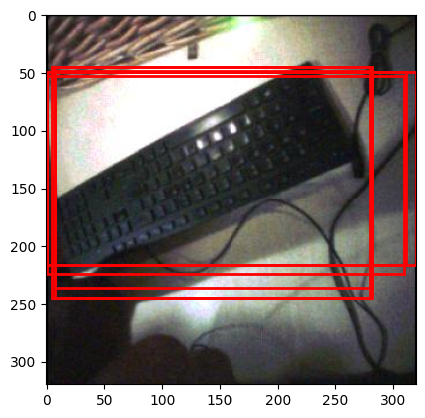

In [57]:
# Load the image
image = plt.imread(IMAGE_PATH)

# Create a figure and axis
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Iterate through bounding boxes in bbox_list and draw them
for bbox in bboxes_nms:
    class_id, score, xmin, ymin, xmax, ymax = bbox
    left = int(xmin * image.shape[1] + 0.5)
    top = int(ymin * image.shape[0] + 0.5)
    width = int((xmax - xmin) * image.shape[1] + 0.5)
    height = int((ymax - ymin) * image.shape[0] + 0.5)

    # Create a Rectangle patch
    rect = patches.Rectangle((left, top), width, height, linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

# Show the image with bounding boxes
plt.show()

In [ ]:
# Print bounding box information
for bbox in bboxes_nms:
    class_id, score, xmin, ymin, xmax, ymax = bbox
    left = int(xmin * image.shape[1] + 0.5)
    top = int(ymin * image.shape[0] + 0.5)
    width = int((xmax - xmin) * image.shape[1] + 0.5)
    height = int((ymax - ymin) * image.shape[0] + 0.5)

    print(f"class: {class_id}, score: {score}, left: {left}, top: {top}, width: {width}, height: {height}")